*Master IASD, PSL - 2023/2024 - O. Cappé, October 2024*

# Retail Store Management

**This is your INDIVIDUAL homework that needs to be returned by November 30, 2024, at the latest, as a functional completed Python notebook file. Late submissions will be applied a penalty.** Please print your name here and be sure to name your file <code>YourFirstName-YOURLASTNAME-retail_store.ipynb</code> and to send it by email to <olivier.cappe@ens.fr> before the deadline.

We consider, the *retail store management* model seen in the course.

You own a bike store. During week $t$, the demand is $D_t$ units, which we may assume to be $\operatorname{Poisson}(d)$ distributed, independently of the past. On Monday morning you may choose to command $A_t$ additional units that are delivered immediately before the shop opens. For each week,

- Maintenance Cost: $h$ per unit left in your stock from previous week
- Ordering Cost: $c$ per ordered unit
- Sales Profit: $f$ per sold unit

With the following constraints

- Your warehouse has a maximal capacity of $m$ unit (any additional bike gets stolen)
- You cannot sell bikes that you don’t have in stock

We will consider that $\mathcal{A}=\mathcal{S}=\{0,\dots,m\}$ and the MDP evolves according to

- $D_t \sim \operatorname{Poisson}(d)$
- $X_t = -h S_t -c A_t + f \min(D_t, S_t + A_t, m)$
- $S_{t+1} = \max(0, \min(S_t+A_t,m)-D_t)$

In [231]:
# Please REFRAIN from importing any additional module
import math
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt

# One more import for vizualization
from tqdm import tqdm

## The Retail Store Environment

The <code>RetailStore</code> class defines the environnement, providing the basic functions for interacting with the system (<code>env.reset</code> and <code>env.step</code>) and for computing basic parameter-dependent quantities (reward and transition functions, value function of a policy).

In [232]:
# Utility functions for the Retail store environment (do NOT modify this code block)

class RetailStore:
    def __init__(self, m, h, c, f, d):
        self.m = m # Stock capacity
        self.h = h # Maintenance cost per unit
        self.c = c # Buying price per unit
        self.f = f # Selling price per unit
        self.d = d # Weekly average demand

    def reset(self, state):
        """ Restarts the environment at time 0 in specified state. """
        self.state = state
        self.time = 0

    def step(self, action):
        """ Given the action, performs one call to the environment and return the reward. """
        demand = poisson.rvs(self.d)
        reward = -self.h*self.state -self.c*action + self.f*min([demand, self.state+action, self.m])
        # Update the time and state variables
        self.time += 1
        self.state = max([min([self.state+action, self.m])-demand, 0])
        return reward

    def reward_function(self):
        """ Computes the action-depend reward function r(s,a). """
        r = np.zeros((self.m+1, self.m+1))
        for s in range(self.m+1):
            for a in range(self.m+1):
                # Note: computing the expectation of the truncated Poisson distribution using the survival function
                r[s, a] = -self.h*s -self.c*a + self.f*sum(poisson.sf(np.linspace(0, min(s+a, self.m)-1, num=min(s+a, self.m)), self.d))
        return r

    def transition_function(self):
        """ Computes the action-depend transition probabilities p(s,a,s'). """
        p = np.zeros((self.m+1, self.m+1, self.m+1))
        for s in range(self.m+1):
            for a in range(self.m+1):
                for i in range(min(s+a, self.m)):
                    p[s, a, min(s+a, self.m)-i] = poisson.pmf(i, self.d)
                p[s, a, 0] = poisson.sf(min(s+a, self.m)-1, self.d)
        return p

    def reward_policy(self, pi):
        """ Computes the reward function r_pi(s) associated with a policy. """
        r = self.reward_function()
        r_pi = np.sum(np.multiply(r, pi), axis=1)
        return r_pi

    def transition_policy(self, pi):
        """ Computes the transition probabilities p_pi(s,s') associated with a policy. """
        p = self.transition_function()
        p_pi = np.zeros((self.m+1, self.m+1))
        for s in range(self.m+1):
            p_pi[s,:] = np.matmul(np.transpose(pi[s,:]), p[s,:,:])
        return p_pi

    def value_policy(self, pi, gamma):
        """ Computes the value function of a policy, with discount gamma (using matrix inversion). """
        r_pi = self.reward_policy(pi)
        p_pi = self.transition_policy(pi)
        v_pi = np.linalg.solve(np.eye(self.m+1) - gamma* p_pi, r_pi)
        return v_pi

## Experiments

### Q1. Simulation of Fixed Ordering Policies

We will consider a small-size model in which $[m, h, c, f, d, \gamma] = [9, 0.1, 0.5, 1, 4, 0.875]$ **(Comment these choice of parameters).** By simulating trajectories from the model **(discuss what length is necessary)** get an empirical idea of **how well fixed-ordering (i.e. ordering always the same quantity of goods) perform?** Use the <code>env.value_policy</code> to **plot the value functions of the fixed-ordering policies.** **What is your interpretation of the results? Do you think that there are better policies?**

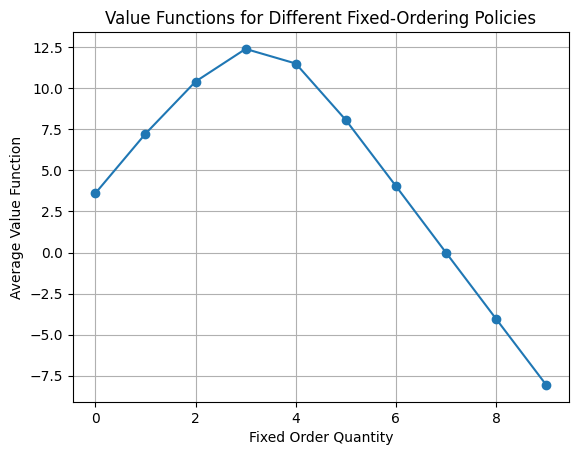

In [233]:
# Instantiate the retail store environment with the selected parameters
[m, h, c, f, d, gamma] = [9, 0.1, 0.5, 1, 4, 0.875]
env = RetailStore(m, h, c, f, d)
verbose = False
# Just an example of simulating a short trajectory and computing the cumulated reward
env.reset(m)
n = 30
w = 1
v = 0
for _ in range(n):
    x = env.step(5)
    if verbose:
        print(env.time-1, ': ', '{:.1f}'.format(x), ' ->', env.state)
    v += w*x
    w *= gamma
if verbose:
    print('Discounted reward:', '{:.1f}'.format(v))

fixed_order_quantities = range(m + 1)
policy_values = []

# Simulate each fixed-ordering policy
for fixed_order in fixed_order_quantities:
    # Construct a policy matrix where each row indicates ordering `fixed_order` units
    pi = np.zeros((m + 1, m+1))
    pi[:, fixed_order] = 1  # Always order `fixed_order` units

    # Compute the value function for this fixed-ordering policy
    v_pi = env.value_policy(pi, gamma)
    policy_values.append(np.mean(v_pi))  # Store the average value across states for comparison

# Plot the results
plt.plot(fixed_order_quantities, policy_values, marker='o')
plt.xlabel("Fixed Order Quantity")
plt.ylabel("Average Value Function")
plt.title("Value Functions for Different Fixed-Ordering Policies")
plt.grid()
plt.show()


*Answer*

Analysis of the parameters:
  - Number of bikes = 9. This is a relatively small stock, which could lead to frequent stockouts if demand is high.
  - Maintenance cost = 0.1. This means that maintaining each item in stock costs 10% of the unit selling price. Higher maintenance costs would discourage holding too much stock.
  - Order cost = 0.5 i.e half of the price sold.
  - Profit = 1. Each unit sold yields a profit of 1, which sets a baseline for revenue potential.
  - Mean of Poisson Distribution = 4. Modeled by a Poisson distribution, this value suggests that 4 units are demanded per week on average, though actual weekly demand will vary around this mean.
  - Gamma = 0.875 Discount factor which is quit close to 1 -> meaning that future rewards are valued highly, which encourages long-term profitability over immediate returns.

A fixed-order policy with a low quantity of bikes results in consistently having zero bikes in stock, but it yields a positive reward since storage costs are minimized. Conversely, ordering larger quantities (around 6-9 bikes) leads to volatile rewards that can be high but also frequently negative, indicating losses due to excess inventory. This approach is therefore inefficient over the long term due to high uncertainty. There is an optimal range for ordering, particularly around 3-5 bikes, where the reward is both stable and substantial.

The plot of the average value function for different fixed-order quantities confirms that the ideal ordering quantity is approximately 3 bikes per week.

I think that there could be a better policy which aims at staying at the same number of bike in the retail shop. For instance each week you order n_desired - n_present. The value of n_desired should be approximately 4/5 in magnitude.

### Q2. Computing the Optimal Policy
Obtain the optimal policy by **implementing the Policy Iteration algorithm** (use the <code>env.value_policy</code> to compute the value function). **How do you know that it has converged?** **What does the optimal policy do?** **Comment the form of the value function.**

Policy Iteration converged after 12 iterations.
Stock Level 0: Order 5 units
Stock Level 1: Order 4 units
Stock Level 2: Order 3 units
Stock Level 3: Order 2 units
Stock Level 4: Order 1 units
Stock Level 5: Order 0 units
Stock Level 6: Order 0 units
Stock Level 7: Order 0 units
Stock Level 8: Order 0 units
Stock Level 9: Order 0 units


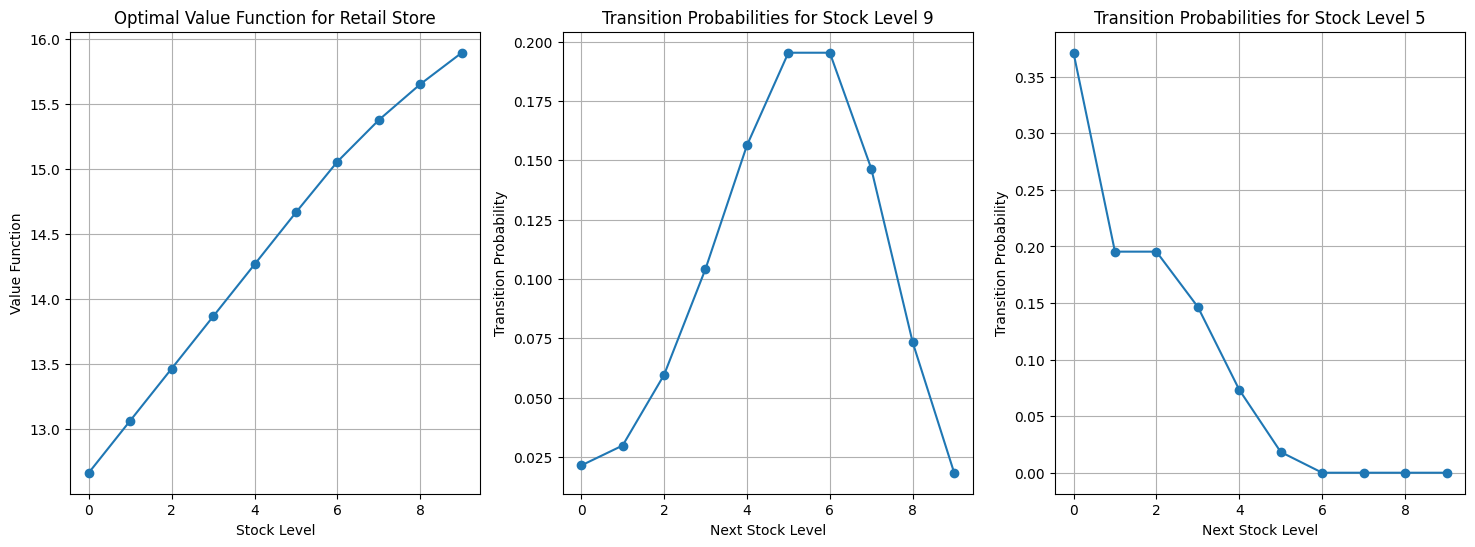

In [ ]:
[m, h, c, f, d, gamma] = [9, 0.1, 0.5, 1, 4, 0.875]
env = RetailStore(m, h, c, f, d)

def policy_iteration(env, gamma, max_iter= 1000, tol=1e-6, max_delay = 10):
    """
    Perform the Policy Iteration algorithm to find the optimal policy for the Retail Store environment.
    Parameters:
        env: RetailStore object
        gamma: float, discount factor
        max_iter: int, maximum number of iterations to perform
        tol: float, tolerance for stopping criterion
        max_delay: int, maximum number of iterations to wait for policy to stabilize
    Returns:
        policy: np.array, optimal policy
        V: np.array, optimal value function
    """
    policy = np.random.randint(0, m + 1, size=(env.m + 1, env.m + 1))
    n_iter = 0
    delay = 0
    while True:
        V = env.value_policy(policy, gamma)
        policy_stable = True
        v_pi = env.value_policy(policy, gamma)
        transition_matrix = env.transition_function()
        reward = env.reward_function()
        next_v = reward + gamma * np.matmul(transition_matrix, v_pi)
        next_actions = np.argmax(next_v, axis=1)
        new_policy = np.zeros_like(policy)
        for s in range(m + 1):
            new_policy[s, next_actions[s]] = 1
        if np.linalg.norm(env.value_policy(new_policy, gamma) - env.value_policy(policy, gamma)) > tol:
            policy_stable = False
            policy = new_policy
        if policy_stable:
            if delay == max_delay:
                print(f"Policy Iteration converged after {n_iter} iterations.")
                return policy, V
            else:
                delay += 1
        elif n_iter >= max_iter:
            break
        n_iter += 1
    print(f"Policy Iteration did not converge after {max_iter} iterations.")
    return policy, V

# Run Policy Iteration
optimal_policy, v_pi = policy_iteration(env, gamma)
for s in range(m + 1):
    print(f"Stock Level {s}: Order {np.argmax(optimal_policy[s])} units")
probabilities = env.transition_policy(optimal_policy)
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
# Plot the optimal value function
ax[0].plot(v_pi, marker='o')
ax[0].set_xlabel("Stock Level")
ax[0].set_ylabel("Value Function")
ax[0].set_title("Optimal Value Function for Retail Store")
ax[0].grid()
ax[1].plot(probabilities[9, :], marker='o')
ax[1].set_xlabel("Next Stock Level")
ax[1].set_ylabel("Transition Probability")
ax[1].set_title("Transition Probabilities for Stock Level 9")
ax[1].grid()
ax[2].plot(probabilities[5, :], marker='o')
ax[2].set_xlabel("Next Stock Level")
ax[2].set_ylabel("Transition Probability")
ax[2].set_title("Transition Probabilities for Stock Level 5")
ax[2].grid()
plt.show()

*Answer*

According to the Policy Improvement Lemma, if the value function under the greedy policy matches that of the previous policy, this indicates that the policy is optimal, as the optimal policy is the fixed point of the greedy policy operator. For computational reasons, we introduced a tolerance to ensure the value function at step i+1 is within epsilon of the value function at step i. We also introduced a delay to confirm this condition and promote convergence. The optimal policy maintains a bike stock level of exactly five— the median stock level— to balance having sufficient inventory without incurring excessive storage costs. One can also notice that important stock leads to higher value function.

### Q3. Q Learning
**Implement the asynchronous Q-Learning algorithm using the purely random policy (all actions selected uniformly) as the exploration policy** (note: this requires only about 10 lines of code). **Plot the convergence of the algorithm** both in terms of convergence of the state-action value table $Q_t$ and of convergence of the value function of the associated greedy policy $\pi_{t+}(s) = \arg\max_a Q_t(s,a)$. Use a single trajectory of length $n = 10,000$ and **test different schemes of decrease** of the learning rate (following the course guidelines). ***Explain the behaviors that you observe***.

100%|██████████| 10000/10000 [00:00<00:00, 24055.70it/s]
/var/folders/tf/1s1659hs28jc69nxhytmsqz00000gn/T/ipykernel_77313/1321807875.py:44: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(q_diffs))


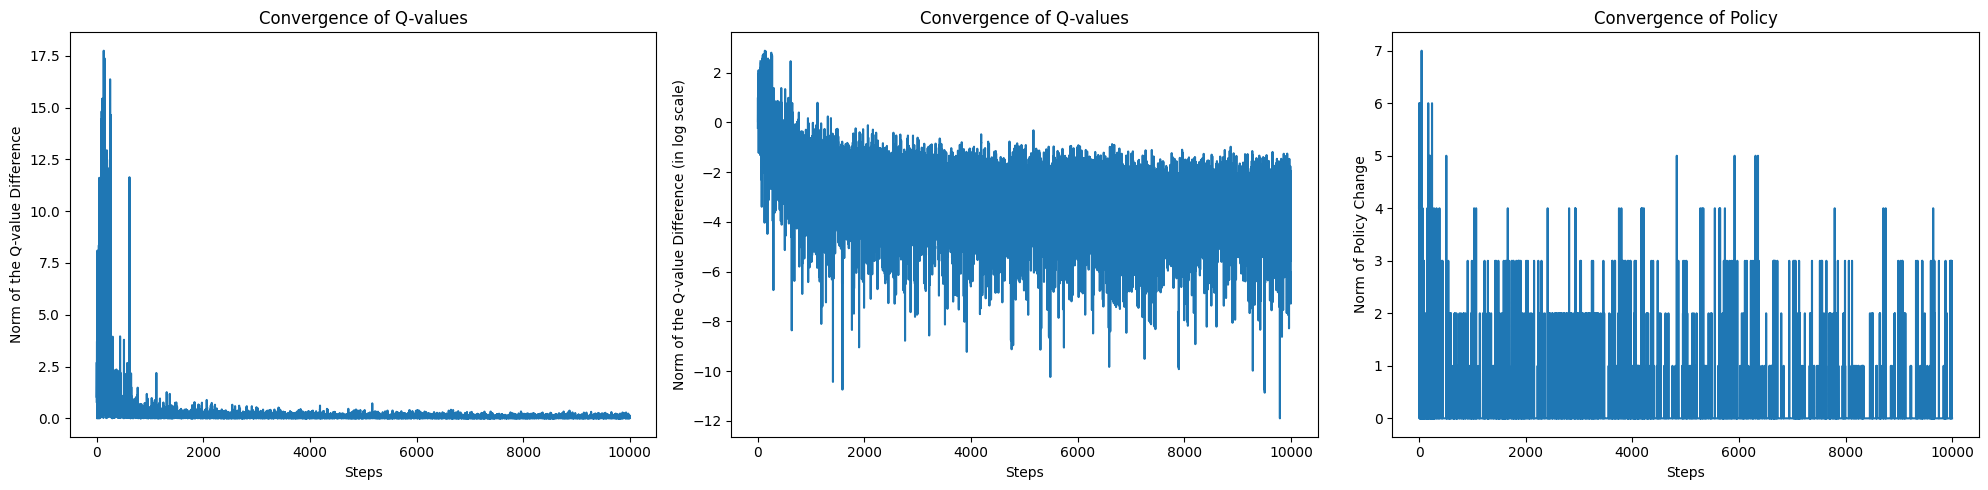

In [ ]:
def asynchronous_Q_learning(env, gamma=0.95, n=10000, beta=0.5):
    """
    Asynchronous Q-learning implementation.

    Parameters:
        env: environment object that has methods `reset` and `step`.
        gamma: discount factor for future rewards.
        n: total number of learning steps.
        beta: exponent for learning rate decay.
        epsilon: exploration rate for epsilon-greedy policy.

    Returns:
        Q: learned Q-table of state-action values.
        Q_list: list of Q-tables at each learning step.
        policy_list: list of policies at each learning step.
    """
    Q = np.zeros((env.m + 1, env.m + 1))
    N = np.zeros((env.m + 1, env.m + 1))
    Q_list = []
    policy_list = []
    # Randomly initialize starting state within allowed range
    state = np.random.randint(0, env.m + 1)
    env.reset(state)

    for i in tqdm(range(n)):
        action = np.random.randint(0, min(env.m - state, env.m) + 1)
        reward = env.step(action)
        next_state = env.state
        max_future_q = np.max(Q[next_state, :min(env.m - next_state + 1, env.m + 1)])
        N[state, action] += 1
        alpha = 1 / (N[state, action] ** beta)  # Diminishing learning rate
        Q[state, action] += alpha * (reward + gamma * max_future_q - Q[state, action])
        state = next_state
        Q_list.append(Q.copy())
        policy = np.argmax(Q, axis=1)
        policy_list.append(policy)
    return Q, Q_list, policy_list

def plot_convergence(Q_list, policy_list, snapshot_interval, gamma=0.95):
    # Plot Q-values convergence
    q_diffs = [np.linalg.norm(Q_list[i + 1] - Q_list[i]) for i in range(len(Q_list) - 1)]

    plt.figure(figsize=(20, 5))
    # Convergence of Q-values
    plt.subplot(1, 3, 2)
    plt.plot(np.log(q_diffs))
    plt.xlabel('Steps')
    plt.ylabel('Norm of the Q-value Difference (in log scale)')
    plt.title('Convergence of Q-values')

    # Plot policy stability over time
    policy_changes= [np.linalg.norm(policy_list[i] - policy_list[i - 1]) for i in range(1, len(policy_list))]

    plt.subplot(1, 3, 1)
    plt.plot(q_diffs)
    plt.xlabel('Steps')
    plt.ylabel('Norm of the Q-value Difference')
    plt.title('Convergence of Q-values')

    plt.subplot(1, 3, 3)
    plt.plot(policy_changes)
    plt.xlabel('Steps')
    plt.ylabel('Norm of Policy Change')
    plt.title('Convergence of Policy')

    plt.tight_layout()
    plt.show()

Q, Q_list, policy_list = asynchronous_Q_learning(env, gamma)

gammas = plot_convergence(Q_list, policy_list, snapshot_interval=100)

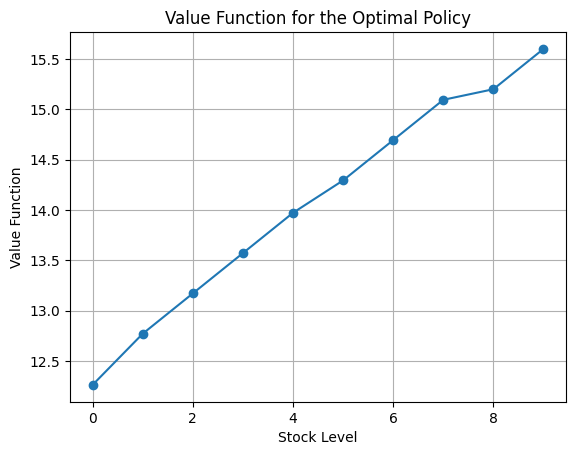

Stock Level 0: Order 4 units
Stock Level 1: Order 5 units
Stock Level 2: Order 4 units
Stock Level 3: Order 3 units
Stock Level 4: Order 2 units
Stock Level 5: Order 2 units
Stock Level 6: Order 1 units
Stock Level 7: Order 0 units
Stock Level 8: Order 1 units
Stock Level 9: Order 0 units


In [348]:
# Extract the optimal policy from the Q-values
optimal_actions = np.argmax(Q, axis=1)
optimal_policy = np.zeros((m + 1, m + 1))
for s in range(m + 1):
    optimal_policy[s, optimal_actions[s]] = 1
v_pi = env.value_policy(optimal_policy, gamma)
plt.plot(v_pi, marker='o')
plt.xlabel("Stock Level")
plt.ylabel("Value Function")
plt.title("Value Function for the Optimal Policy")
plt.grid()
plt.show()
for s in range(m + 1):
    print(f"Stock Level {s}: Order {np.argmax(optimal_policy[s])} units")

*Answer*

It appears that the convergence of the Q-value and the optimal policy improves as beta increases. While the Q table seems to be converging, it's not immediately clear that the optimal policy is consistently reaching convergence in each run. The distance between consecutive policies decreases, but it doesn't quite reach zero. The optimal policy in this case involves ordering a large quantity of bikes (5-6 units) when stock is low and gradually reducing the number of bikes ordered as stock levels increase.

### Q4. Policy Gradient

We will now consider using policy gradient from a set of simulated trajectories using the REINFORCE formula to approximate the gradient of the value function. To do so, we consider a log-linear parameterization of the policy and provide the two utility functions below.

<code>policy_features</code> Computes a $2(m+1)$--dimensional feature vector $\phi(s,a)$ corresponding to the state-action pair $(s,a)$.

<code>policy_choice</code> Computes the vector $\pi_\theta(s,:)$ of action probabilities using the softmax operator:
$$
    \pi_\theta(s,a) = \frac{\exp\left(\theta^T \phi(s,a)\right)}{\sum_{a'=0}^m \exp\left(\theta^T \phi(s,a')\right)}
$$
You should check from the code that the matrix $(\theta^T \phi(s,a))_{0\leq s,a \leq n}$ is a weighted sum of the $m+1$ fixed ordering policies and of the $m+1$ threshold policies (which you should have met already...)

In [349]:
# Policy gradient utility functions (do NOT modify this code block)

def policy_features(s, a, m):
    """Returns the feature vector corresponding to state (s,a)."""
    f = np.zeros(2*(m+1))
    # Index of the fixed ordering policy that is non zero in (s,a)
    f[a] = 1
    # Indices of the threshold policies that are non zero in (s,a)
    if (s+a <= m):
        f[(m+1)+s+a] = 1
    if (a == 0):
        for i in range(0,s+1):
            f[(m+1)+i] = 1
    return f

def policy_choice(s, m,theta):
    """Returns the vector of action probabilities pi(s,:) corresponding to state s and parameter theta."""
    pi = np.zeros(m+1)
    # Note : Computation in log to avoid numerical underflows
    for a in range(m+1):
        pi[a] = np.dot(policy_features(s, a, m), theta)
    pi = pi - np.max(pi)
    pi = np.exp(pi)/np.sum(np.exp(pi))
    return pi

**Code a function** <code>policy_gradient</code> that computes the gradient $\nabla_\theta \log\pi_\theta(s,a)$. First **write in the text block below the LaTeX formula implemented by the function, explaining how you obtain this formula.**

--- _Your answer here_ ---
The gradient of the log-probability \(\log \pi_\theta(s,a)\) with respect to the parameter \(\theta\) can be computed using the policy gradient theorem. The formula is derived as follows:
The gradient of the log-probability \(\log \pi_\theta(s,a)\) with respect to the parameter \(\theta\) can be computed using the policy gradient theorem. The formula is derived as follows:

### Formula:
\[
\nabla_\theta \log \pi_\theta(s,a) = \nabla_\theta \left( \log \left( \frac{ \exp( \theta^T f(s,a) ) }{ \sum_{a'} \exp( \theta^T f(s, a')) } \right) \right)
\]

The steps to derive this are:

1. **Log of the action probability:**

   We start with the expression for the probability of taking action \(a\) in state \(s\), which is:
   \[
   \pi_\theta(s,a) = \frac{ \exp( \theta^T f(s,a) ) }{ \sum_{a'} \exp( \theta^T f(s, a')) }
   \]

   Taking the logarithm of this expression:
   \[
   \log \pi_\theta(s,a) = \theta^T f(s,a) - \log \left( \sum_{a'} \exp( \theta^T f(s, a')) \right)
   \]

2. **Differentiating with respect to \(\theta\):**

   Now, we take the gradient of \(\log \pi_\theta(s,a)\) with respect to \(\theta\). The gradient of the first term is straightforward:
   \[
   \nabla_\theta \left( \theta^T f(s,a) \right) = f(s,a)
   \]

   For the second term, we apply the chain rule to the logarithm:
   \[
   \nabla_\theta \log \left( \sum_{a'} \exp( \theta^T f(s, a')) \right) = \frac{\sum_{a'} \exp( \theta^T f(s, a')) \cdot \nabla_\theta \left( \theta^T f(s, a') \right)}{\sum_{a'} \exp( \theta^T f(s, a'))}
   \]
   Simplifying, this becomes:
   \[
   \sum_{a'} \pi_\theta(s,a') f(s,a')
   \]

3. **Final gradient expression:**

   Combining both terms, the gradient of \(\log \pi_\theta(s,a)\) with respect to \(\theta\) is:
   \[
   \nabla_\theta \log \pi_\theta(s,a) = f(s,a) - \sum_{a'} \pi_\theta(s,a') f(s,a')
   \]


In [ ]:
def policy_gradient(s, a, m, theta):
    """
    Computes the gradient of log(pi_theta(s, a)) with respect to theta.

    Arguments:
    - s: state
    - a: action taken
    - m: the maximum action index
    - theta: parameter vector

    Returns:
    - gradient: the gradient of log(pi_theta(s, a)) with respect to theta
    """
    # Get the feature vector for the given state and action
    f_sa = policy_features(s, a, m)

    # Compute the probabilities pi(s, a') for all actions a'
    pi = policy_choice(s, m, theta)

    # Compute the gradient
    gradient = f_sa - np.dot(pi, np.array([policy_features(s, a_prime, m) for a_prime in range(m+1)]))

    return gradient

**Implement the policy gradient algorithm** approximating the gradients using the REINFORCE formula
$$
  \sum_{t=0}^{n} \gamma^t \left(\sum_{i=0}^{n} \gamma^i X_{t+i} \right) \nabla_\theta \log \pi_\theta(S_t, A_t)
$$
computed on trajectories of length 35 started from a random initial state and using 200 iterations of SGD updates. To do so, complete the code template provided below. **Monitor the convergence of the algorithm by plotting the difference between the mean of the optimal value function and the mean of the value functions corresponding to successive values of $\theta$ (explain why one considers the mean). Run the algorithm several times with the same and then different parameters (number of iterations, learning rate). What do you observe?**

In [238]:
# --- Your answer here (edit this block as needed) ---
n = 35
nb_iter = 200

theta = np.zeros(2*(m+1))
for i_iter in range(nb_iter):
    # Compute the REINFORCE approximation of the gradient of the value function from a run of length n
    # of the MDP initialized t a random state and using the policy corresponding to the current value of theta

    grad = np.zeros(2*(m+1))  # --- Something better than this is needed here! ---

    # Do a step of SGD update on theta
    theta += 0.1*np.power(1+i_iter, -0.6)*grad

--- Your answser here ---